# Patient Readmission Exploration
#### Author: Izzy Valdivia
##### November 2025

### Project Background: 
&nbsp;&nbsp;&nbsp;&nbsp; Patient readmission is a powerful indicator of quality of care across the healthcare industry. Readmission is when a person is admitted to the hospital within 30 days of a previous discharge because there was some aspect of their care that was not handled or their condition is worsening. Health care providers and insurers frequently track patient readmission rates from hospital systems to better understand the quality of care provided at those facilities and how that affects patient outcomes. Understanding which hospitals have high readmission rates can help policymakers and insurers launch targeted improvement programs or understand what areas may need more resources. Definitive Healthcare, an analytics company focused on reporting on healthcare metrics in the United States, reports that the average hosiptal readmission rate is ~14.7%, with a range from 10.1 to 19.1% ([Definitive Healthcare, 2025](https://www.definitivehc.com/resourcesz/healthcare-insights/average-hospital-readmission-state#:~:text=What%20is%20the%20average%20hospital,to%2019.1%25%20in%20the%20U.S.)).  
&nbsp;&nbsp;&nbsp;&nbsp; With this context in mind, I am interested in creating a model to predict hospital readmission rates based on quality of care metrics for the Medicare population. I hope to understand what facets of quality of care most impact patient readmission rate for medicare patients. To do this I would most likely perform a regression analysis of readmission rate for each hospital/care system and their corresponding care metrics. Understanding the relationships between patient readmission and quality of care could also help policymakers adjust provider and insurer incentive structures to prioritize the health of individuals.

### Related Work: 
&nbsp;&nbsp;&nbsp;&nbsp; There has been some research done about hospital readmission rate that is tangential to the analysis I am aiming to complete. A paper published in 2020 found that looking at a specific subset of care quality measures, specifically patient satisfaction, leads to lower readmissions rates (Chen et al., 2020). Similarly, the Agency for Healthcare Research and Quality came out with a Re-Engineered Discharge toolkit that predicts a hospital’s readmission rate based on their member mix. While both of these resources analyze how certain healthcare factors affect a hospital’s readmission rate, I would like to examine this issue with a more comprehensive view. This project will be a multi-faceted approach to examining readmission rates using both clinical factors like timeliness while also incorporating structural aspects such as hospital funding sources and the type of hospital.

### Research Questions: 
In order to explore the relationship between hospital quality of care metrics and their patients’ corresponding readmissions rates, I will base my analysis on the following questions: 
* What are the current patterns and distributions of patient readmission rates across the Medicare hospitals and how do they vary by hospital ownership type or location? 
* What quality of care metrics, like timeliness, patient experience, and emergency room wait times are most strongly associated with readmission rate?
* How effective can a multivariate regression model predict readmission rates based on the available quality of care metrics and structural aspects of the hospitals, and how does this prediction power compare across the different types of hospitals?



### Data Sources:  
&nbsp;&nbsp;&nbsp;&nbsp;All data collected for this project came [data.cms.gov](data.cms.gov). First of which is the [Hospital General Information dataset](https://data.cms.gov/provider-data/dataset/xubh-q36u#overview) which contains information on all hospitals that have registered with Medicare. Some of the information in this dataset includes address, type of hospital, ownership type (i.e. non-profit, government) and overall rating. Next I will be using the [Hospital Readmissions Reduction Program (HRRP)](https://data.cms.gov/provider-data/dataset/9n3s-kdb3) dataset, which includes information about the number of discharges, number of readmissions, and ratio of readmissions for each facility that is registered with Medicare. The readmission rate would be the outcome variable for the predictive model. Next, I will be using the [Timely and Effective Care](https://data.cms.gov/provider-data/dataset/yv7e-xc69) table that contains information on how hospitals perform on a variety of clinical measures like average time patients wait to be seen in the emergency department and appropriate care rating given to patients with sepsis. These measures are available for each of the hospitals that are registered with Medicare, so the measure ratings could be used as predictors for readmission rate. The license for all of these data sets is not explicitly stated, but according to an FAQ guide for using data from data.cms.gov, “Works of the U.S. Government are in the public domain and you don’t need permission to reuse them, but an attribution to the agency as the source is appreciated.” 

This analysis is being done in November 2025. Data version information is as follows: 

| Table | CSV Name | Last Updated | Release Date | 
| -------- | ------- | ------- | ------- |
| Hospital General Information | Hospital_General_Information.csv | 07-16-2025 | 08-06-2025 |
| Hospital Readmissions Reduction Program | FY_2025_Hospital_Readmission_Reduction_Program_Hospital.csv | 01-08-2025 | 08-06-2025 |
| Timely and Effective Care | Timely_and_Effective_Care-Hospital.csv | 07-24-2025 | 08-06-2025 |

### Methodology: 
&nbsp;&nbsp;&nbsp;&nbsp;In order to carry out the investigation outlined in the research questions section of this plan, I will do the following. First, I will do an exploratory analysis of the data and analyze the distribution of readmission rates and ownership types of all registered Medicare hospitals. This will help establish a baseline understanding of the data that can be referenced along with my further analyses. In order to answer the question of whether or not readmission rate varies across ownership types, I will perform an ANOVA test, which will inform whether or not more tests are necessary.  
&nbsp;&nbsp;&nbsp;&nbsp;Next, to answer the second research question about identifying which quality of care metrics are most associated with large readmission rates, I will perform a correlation analysis. This will identify which, if any, of the quality of care metrics are correlated with readmissions and whether or not that correlation is positive or negative. In the case there are many correlated predictor variables I will use LASSO to select only a subset of the most important variables. Important in this context meaning the variables that explain the most variability in the outcome variable.   
&nbsp;&nbsp;&nbsp;&nbsp;Finally, to address the third research question, I will fit a multivariate logistic regression model as well as a random forest model with the quality of care and hospital-specific variables as the predictors. I will compare the R^2, RMSE and MAE values across both model types to evaluate which is the better predictor. Similarly, I will evaluate the models for interpretability. 


In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import textwrap


# HELPER FUNCTIONS:
def check_nulls(df):
    # Calculate null percentage for each column in tec_filtered_wider
    total_rows = df.shape[0]
    print(f"Total rows in tec_filtered_wider: {total_rows}\n")
    print("="*80)
    print(f"{'Column Name':<50} {'Null Count':>12} {'Null %':>10}")
    print("="*80)

    null_percentages = []
    for col in df.columns:
        null_count = df[col].null_count()
        null_pct = (null_count / total_rows) * 100
        null_percentages.append({
            'Column': col,
            'Null_Count': null_count,
            'Null_Percentage': null_pct
        })
        print(f"{col:<50} {null_count:>12} {null_pct:>9.2f}%")

    # Create a summary DataFrame sorted by null percentage
    null_df = pd.DataFrame(null_percentages).sort_values('Null_Percentage', ascending=False)
    print("\n" + "="*80)
    print(f"\nSummary Statistics:")
    print(f"  Columns with 0% null: {(null_df['Null_Percentage'] == 0).sum()}")
    print(f"  Columns with < 10% null: {(null_df['Null_Percentage'] < 10).sum()}")
    print(f"  Columns with 10-50% null: {((null_df['Null_Percentage'] >= 10) & (null_df['Null_Percentage'] < 50)).sum()}")
    print(f"  Columns with >= 50% null: {(null_df['Null_Percentage'] >= 50).sum()}")
    print(f"  Average null percentage: {null_df['Null_Percentage'].mean():.2f}%")
 
def get_dataset_stats(table, name): 
    table_shape = table.shape
    table_rows = table_shape[0]
    table_cols = table_shape[1]

    print(f"The {name} table has has {table_rows} rows and {table_cols} columns")

def create_distribution(data_frame, variable_name, label_name, sorted=False, sorting_col='none', title_flag=False, title="none", rotation=0, bar_color='skyblue'):
    avar = variable_name

    if sorted: 
        grouped_df_counts = data_frame.group_by(avar).agg(
            pl.len().alias(f"{label_name}_count"), 
            pl.col(sorting_col).first().alias("sort_order")
        )
        grouped_df_counts = grouped_df_counts.sort("sort_order")
    else: 
        grouped_df_counts = data_frame.group_by(avar).agg(
            pl.len().alias(f"{label_name}_count"), 
        )
        grouped_df_counts = grouped_df_counts.sort(avar)

    categories = grouped_df_counts[avar]
    category_counts = grouped_df_counts[f"{label_name}_count"]
    
    fig, ax = plt.subplots(figsize=(10, 5)) # Increase figure width
    bars = ax.bar(categories, category_counts)
    ax.bar_label(bars)
    ax.bar(categories, category_counts, color=bar_color)
    ax.set_xlabel(label_name)
    plt.xticks(rotation=rotation)
    plt.gca().set_xticklabels(
    [textwrap.fill(label.get_text(), 12) for label in plt.gca().get_xticklabels()]
)

    ax.set_ylabel(f"{label_name} Count")
    if title_flag:
        plt.title(title)
    else:
        plt.title(f"Distribution of {label_name}")
    plt.show()


def quartile_statistics(df,col): 
    print(df.select(
    pl.col(col).cast(pl.Float64).quantile(0.25).alias(f"Q1 {col}"),
    pl.col(col).cast(pl.Float64).mean().alias(f"Mean {col}"), 
    pl.col(col).cast(pl.Float64).quantile(0.75).alias(f"Q3 {col}")
    ))



| Table | CSV Name | Unique Facility IDs | Num Rows | Num Columns |
| -------- | ------- | ------- | ------- | ------- |
| Hospital General Information | Hospital_General_Information.csv | 5381 | 5381 | 38 |
| Hospital Readmissions Reduction Program | FY_2025_Hospital_Readmission_Reduction_Program_Hospital.csv | 3085 | 18510 | 12 |
| Timely and Effective Care | Timely_and_Effective_Care-Hospital.csv | 4623 | 117933 | 16 |

In [3]:
#### Load in Datasets
# Hospital General Information
hgi = pl.read_csv('../data/Hospital_General_Information.csv')
get_dataset_stats(hgi, "hgi")

# Readmission Reduction Program
rrp = pl.read_csv('../data/FY_2025_Hospital_Readmissions_Reduction_Program_Hospital.csv', schema_overrides={'Facility ID': pl.String})
get_dataset_stats(rrp, "RRP")

# Timely and Effective Care
tec = pl.read_csv('../data/Timely_and_Effective_Care-Hospital.csv', schema_overrides={'Facility ID': pl.String})
get_dataset_stats(tec, "tec")


The hgi table has has 5381 rows and 38 columns
The RRP table has has 18510 rows and 12 columns
The tec table has has 117933 rows and 16 columns


In [4]:
facilities_tec = tec['Facility ID'].unique().shape[0]
facilities_hgi = hgi['Facility ID'].unique().shape[0]
facilities_rrp = rrp['Facility ID'].unique().shape[0]

print(f"The number of unique facility IDs in the Timeliness and Effective Care dataset is {facilities_tec}")
print(f"The number of unique facility IDs in Hospital General Information dataset is {facilities_hgi}")
print(f"The number of unique facility IDs in Readmissions Reduction Program dataset is {facilities_rrp}")


# print(f"numrows of tec is {tec_rows}")

The number of unique facility IDs in the Timeliness and Effective Care dataset is 4623
The number of unique facility IDs in Hospital General Information dataset is 5381
The number of unique facility IDs in Readmissions Reduction Program dataset is 3085


The Readmissions Reduction Program dataset was last updated in January, the most distant of the 3 datasets. It also has the lowest number of unique hospital Facility IDs (Primary Key), so I'm checking to make sure both the Timely and Effective Care as well as the Hospital General Information tables have all of the Facility IDs contained in the RRP dataset. 


## Pre-processing: 
I am beginning by doing some minor pre-processing of the TEC data frame. I will be filtering to include data that has a start date of 1/1/2023 and and end date at the end of '23. This is because the RRP dataset only includes data through June 2023, therefore I will be filtering out the TEC dataframe's data from 2024. 

In [5]:
# Filter Readmissions Table
rrp_filtered = rrp.filter((pl.col("Measure Name") == "READM-30-AMI-HRRP") & (pl.col("Predicted Readmission Rate") != "N/A")).drop(["Footnote", "Start Date", "End Date", "Number of Discharges", "Excess Readmission Ratio", "Measure Name", "Expected Readmission Rate", "Number of Readmissions"])
rrp_filtered = rrp_filtered.with_columns(
    pl.col("Predicted Readmission Rate")
    .cast(pl.Float64)
    .alias("Readmission Rate")
).drop("Predicted Readmission Rate")
rrp_filtered


Facility Name,Facility ID,State,Readmission Rate
str,str,str,f64
"""SOUTHEAST HEALTH MEDICAL CENTE…","""010001""","""AL""",13.0146
"""NORTH ALABAMA MEDICAL CENTER""","""010006""","""AL""",11.875
"""ST. VINCENT'S EAST""","""010011""","""AL""",11.8541
"""DEKALB REGIONAL MEDICAL CENTER""","""010012""","""AL""",11.2791
"""SHELBY BAPTIST MEDICAL CENTER""","""010016""","""AL""",14.4337
…,…,…,…
"""BAYLOR SCOTT & WHITE MEDICAL C…","""670088""","""TX""",12.6608
"""RESOLUTE HEALTH HOSPITAL""","""670098""","""TX""",13.1611
"""MEDICAL CITY ALLIANCE""","""670103""","""TX""",12.0481


In [6]:
tec = tec.filter(pl.col('Start Date') == "01/01/2023")
tec_filtered = tec.drop(["Facility Name", "Address", "City/Town", "ZIP Code", "County/Parish", "Telephone Number", "Start Date", "End Date", "Footnote"])

# filter out any rows where the score is Not Available or Null: 
tec_filtered = tec_filtered.filter(
    pl.col("Score") != "Not Available"
)
tec_filtered_pivoted = tec_filtered.pivot("Measure ID", index="Facility ID", values="Score")
# display(check_nulls(tec_filtered_pivoted))

tec_filtered_wider = tec_filtered_pivoted.drop(["ED_2_Strata_2", "OP_31", "OP_40", "HH_02", "HH_01", "STK_03", "ED_2_Strata_1", "STK_05", "STK_02", "STK_06", "VTE_2", "VTE_1"])
tec_filtered_wider = tec_filtered_wider.filter(
    pl.col("EDV").is_not_null(), 
    pl.col("OP_22").is_not_null(), 
    pl.col("SAFE_USE_OF_OPIOIDS").is_not_null(),
    pl.col("OP_29").is_not_null()
)
# Convert OP_22, OP_29 & SAFE_USE_OF_OPIOIDS to floats: 
tec_filtered_wider = tec_filtered_wider.with_columns(
    pl.col("OP_22").cast(pl.Float64),
    pl.col("OP_29").cast(pl.Float64),
    pl.col("SAFE_USE_OF_OPIOIDS").cast(pl.Float64)
)

In [7]:
hgi_filtered = hgi.drop(["State", "Hospital Type", "City/Town", "ZIP Code", "Telephone Number", "Address", "County/Parish", "Facility Name"]).with_columns(
    pl.col("Meets criteria for birthing friendly designation").fill_null("N")
    )

for col in hgi_filtered.columns: 
    if "footnote" in col.lower(): 
        hgi_filtered = hgi_filtered.drop(col)

filtered_cols = hgi_filtered.columns

hgi_filtered = hgi_filtered.filter(
    (pl.col("Hospital overall rating") != "Not Available"),
    (pl.col("Count of Facility MORT Measures") != "Not Available"),
    (pl.col("Count of Facility Safety Measures") != "Not Available"),
    (pl.col("Count of Facility Pt Exp Measures") != "Not Available")
    
)
cols_to_convert = filtered_cols[5:]
for col_convert in cols_to_convert: 
    # Convert columns to floats
    hgi_filtered = hgi_filtered.with_columns(
        pl.col(col_convert).cast(pl.Float64)
    )
    # Remove columns that only have one non-null value -- they don't have any valuable information 
    if len(hgi_filtered[col_convert].unique())==1: 
        hgi_filtered = hgi_filtered.drop(col_convert)
hgi_filtered.head()



Facility ID,Hospital Ownership,Emergency Services,Meets criteria for birthing friendly designation,Hospital overall rating,Count of Facility MORT Measures,Count of MORT Measures Better,Count of MORT Measures No Different,Count of MORT Measures Worse,Count of Facility Safety Measures,Count of Safety Measures Better,Count of Safety Measures No Different,Count of Safety Measures Worse,Count of Facility READM Measures,Count of READM Measures Better,Count of READM Measures No Different,Count of READM Measures Worse,Count of Facility TE Measures
str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""010001""","""Government - Hospital District…","""Yes""","""Y""","""4""",7.0,0.0,7.0,0.0,7.0,3.0,4.0,0.0,11.0,0.0,11.0,0.0,11.0
"""010005""","""Government - Hospital District…","""Yes""","""N""","""3""",6.0,0.0,5.0,1.0,7.0,0.0,7.0,0.0,9.0,0.0,8.0,1.0,12.0
"""010006""","""Proprietary""","""Yes""","""Y""","""2""",7.0,0.0,5.0,2.0,8.0,3.0,5.0,0.0,9.0,0.0,8.0,1.0,10.0
"""010007""","""Voluntary non-profit - Private""","""Yes""","""N""","""1""",3.0,0.0,2.0,1.0,3.0,0.0,3.0,0.0,7.0,0.0,7.0,0.0,7.0
"""010011""","""Voluntary non-profit - Private""","""Yes""","""N""","""2""",7.0,0.0,6.0,1.0,7.0,3.0,4.0,0.0,9.0,0.0,8.0,1.0,8.0


### Create merged table: 
Left join with filtered TEC table on the Facility ID column followed by a left join with the HGI table on Facility ID. 

In [8]:
# created joined table: 
rrp_tec = rrp_filtered.join(tec_filtered_wider, on="Facility ID", how="left")
full_table = rrp_tec.join(hgi_filtered, on="Facility ID", how="left")
full_table

# Remove null rows after joining: 
full_table = full_table.filter(
    pl.col("EDV").is_not_null(), 
    pl.col("Emergency Services").is_not_null()
)
check_nulls(full_table)

Total rows in tec_filtered_wider: 1573

Column Name                                          Null Count     Null %
Facility Name                                                 0      0.00%
Facility ID                                                   0      0.00%
State                                                         0      0.00%
Readmission Rate                                              0      0.00%
EDV                                                           0      0.00%
OP_22                                                         0      0.00%
OP_29                                                         0      0.00%
SAFE_USE_OF_OPIOIDS                                           0      0.00%
Hospital Ownership                                            0      0.00%
Emergency Services                                            0      0.00%
Meets criteria for birthing friendly designation              0      0.00%
Hospital overall rating                                     

### Remove redundant columns
There are some columns that repeat between the 3 datasets like Facility Name, Address, State and Telephone Number. 

## Research Question # 1: 
#### What are the current patterns and distributions of patient readmission rates across the Medicare hospitals and how do they vary by hospital type, funding source, size and location? 

/var/folders/d_/hxjmz8y17js99kwby_186kcc0000gn/T/ipykernel_38948/3611484716.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(


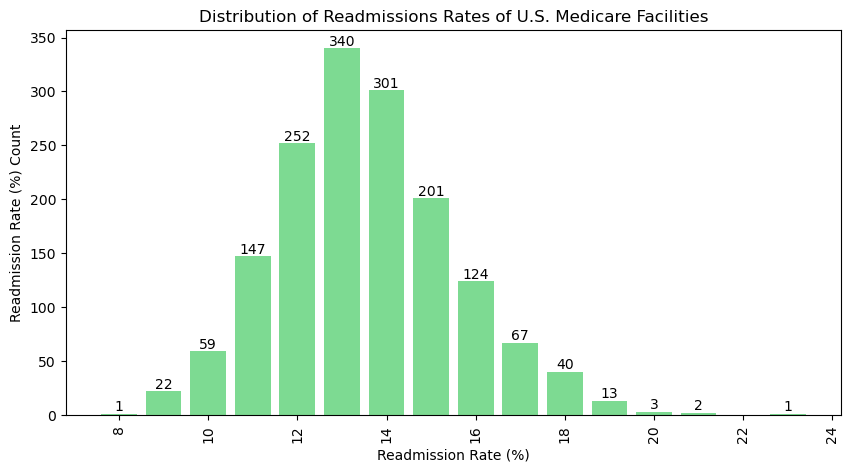

In [9]:
num_read ="Readmission Rate"
rfn = "readmissions_floor_num"

grouped_rrp = full_table.group_by("Facility ID").agg(
    pl.col(num_read).cast(pl.Float64).sum().round().alias(num_read)
)

df_binned = (
    grouped_rrp
    .with_columns(
        pl.col(num_read).cast(pl.Int64)
    )
    .with_columns(
        (pl.col(num_read) // 1 * 1)
            .alias(rfn)
    )
    .with_columns(
        (
            pl.col(rfn).cast(pl.Utf8)
            + "-"
            + (pl.col(rfn)).cast(pl.Utf8)
        ).alias("readmissions_floor")
    )
)

grouped_rrp.head()
create_distribution(grouped_rrp, 
                    num_read, 
                    "Readmission Rate (%)", 
                    True, 
                    num_read,
                    True,
                    "Distribution of Readmissions Rates of U.S. Medicare Facilities",
                    90, 
                    bar_color="#7dda92"
                )


Get distribution of the Number of Hosiptals in each state:

/var/folders/d_/hxjmz8y17js99kwby_186kcc0000gn/T/ipykernel_38948/3611484716.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(


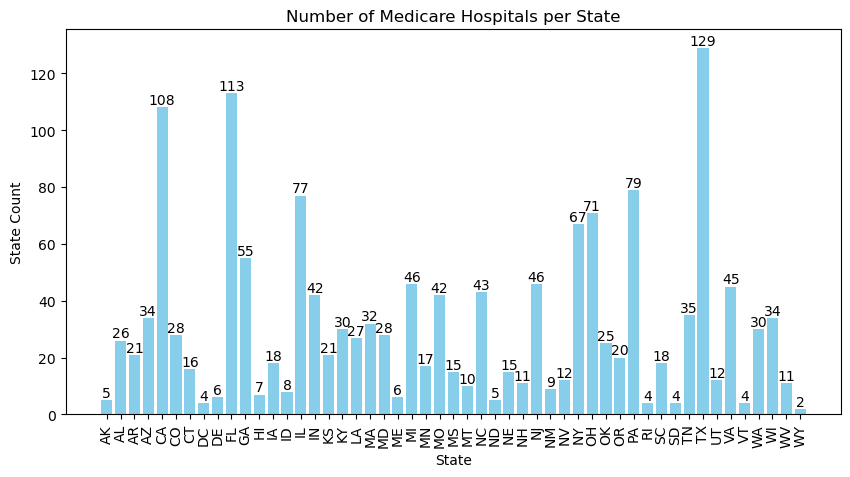

In [10]:
create_distribution(full_table, "State", "State", rotation=90, title_flag=True, title="Number of Medicare Hospitals per State")

Get the Distribution of number of hospitals by ownership type

/var/folders/d_/hxjmz8y17js99kwby_186kcc0000gn/T/ipykernel_38948/3611484716.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(


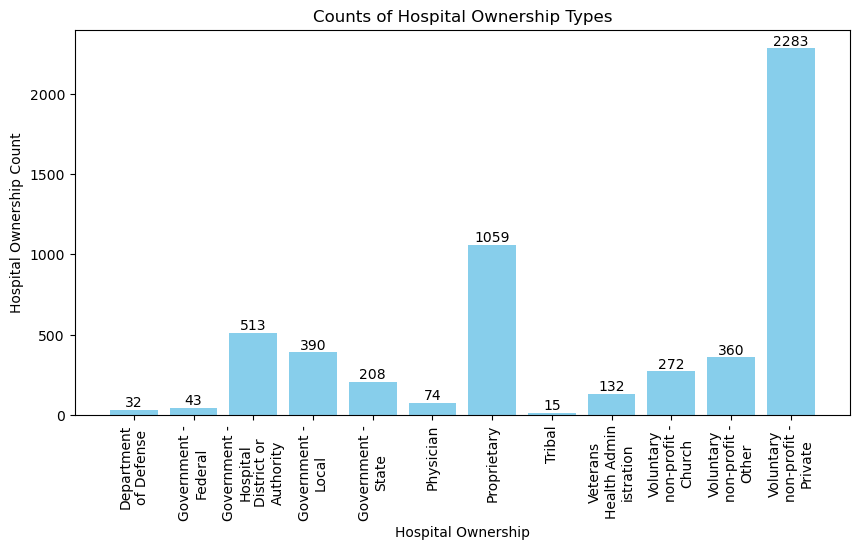

In [11]:
create_distribution(hgi, "Hospital Ownership", "Hospital Ownership", title_flag=True, title="Counts of Hospital Ownership Types", rotation=90)

In [12]:
# Get the average predicted readmission rate as well as the quartiles
quartile_statistics(full_table, 'Readmission Rate')


shape: (1, 3)
┌─────────────────────┬───────────────────────┬─────────────────────┐
│ Q1 Readmission Rate ┆ Mean Readmission Rate ┆ Q3 Readmission Rate │
│ ---                 ┆ ---                   ┆ ---                 │
│ f64                 ┆ f64                   ┆ f64                 │
╞═════════════════════╪═══════════════════════╪═════════════════════╡
│ 12.1678             ┆ 13.534826             ┆ 14.7012             │
└─────────────────────┴───────────────────────┴─────────────────────┘


### ANOVA Test #1: Readmission rate & Hospital Ownership 
In order to analyze whether a hospital's type, funding type or location affect the readmission rate, I will perform an ANOVA test. In this first case, the null hypothesis ($H_0$) is that there is no significant difference in any of the mean readmission rates between different hospital ownership types with an $\alpha$ value of 0.05. The alternative hypothesis ($H_a$) in this case would be that there is at least one group mean that is different from the others. As is the case with ANOVA tests, a large F-statistic coupled with a small p-value (< $\alpha$) is enough evidence to reject $H_0$. A large p-value and small F-statistic would not provide enough evidence to reject $H_0$. 

In [13]:
from scipy.stats import f_oneway, f


df = full_table.to_pandas()
grps = [d['Readmission Rate'] for _, d in df.groupby("Hospital Ownership")]
f_statistic, p_value = f_oneway(*grps)

# Calculate the f critical value: 
alpha = 0.05
dfn = 9 # <-- number of groups - 1
dfd = full_table.shape[0] # <-- total number of observations
f_critical = f.ppf(q=1 -alpha, dfn=dfn, dfd=dfd)

# Display the results: 
print(f"The f statistic associated with the ANOVA test is: {round(f_statistic, 4)}")
print(f"The critical F value is {f_critical}")
print(f"The p-value associated with the ANOVA test is: {round(p_value,10)}")

The f statistic associated with the ANOVA test is: 4.3205
The critical F value is 1.885820227809345
The p-value associated with the ANOVA test is: 1.42053e-05


Given that there is an F-statistic larger than the critical F value and the p-value is less than the $\alpha$ value chosen for this test, there is enough evidence to reject $H_0$. This means that not all of the group mean readmission rates are the same. In order to determine which of the 10 group means vary from the others, I will have to follow up with different tests. This will be covered later in the analysis. 

### ANOVA Test #2: Readmission Rate & Location
I will perform a second ANOVA test, this time testing readmission rate differences by location. The null hypothesis ($H_0$) is that there is no significant difference in any of the mean readmission rates between States. Like the first test, the $\alpha$ value is 0.05. The alternative hypothesis ($H_a$) in this case would be that there is at least one group mean that is different from the others.

In [14]:
df = full_table.to_pandas()
grps = [d['Readmission Rate'] for _, d in df.groupby("State")]
f_statistic, p_value = f_oneway(*grps)

# Calculate the f critical value: 
alpha = 0.05
dfn = full_table['State'].unique().shape[0] # <-- number of groups - 1
dfd = full_table.shape[0] # <-- total number of observations
f_critical = f.ppf(q=1 -alpha, dfn=dfn, dfd=dfd)


# Display the results: 
print(f"The f statistic associated with the 2nd ANOVA test is: {round(f_statistic, 4)}")
print(f"The critical F value is {f_critical}")
print(f"The p-value associated with the 2nd  ANOVA test is: {p_value}")

The f statistic associated with the 2nd ANOVA test is: 11.1439
The critical F value is 1.354849539029923
The p-value associated with the 2nd  ANOVA test is: 5.531719236699497e-72


Similarly to the first ANOVA test, the 2nd one that is looking at differences in mean readmission rate based on location has enough evidence to reject $H_0$. The p-value is 5.53e<sup>-72</sup>, and the F-statistic, 11.144, is larger than the crifical F value of 1.355 which both support the fact that the $H_0$ should be rejected.

## Research Question #2: 
#### What quality of care metrics, like timeliness, patient experience, and emergency room wait times are most strongly associated with readmission rate?

In order to investigate this question, I will begin by perfroming a correlation analysis between the quality of care metrics and the readmissions rates for each hospital.


Updated Correlations with ED Volume:
Count of READM Measures Better                        -0.290620
Hospital overall rating                               -0.240863
Count of Facility TE Measures                         -0.236914
Count of READM Measures No Different                  -0.186905
Count of Facility READM Measures                      -0.138211
Count of MORT Measures Worse                          -0.111859
meet_birthing_friendly_designation_criteria_encoded   -0.104177
OP_29                                                 -0.094654
Count of MORT Measures No Different                   -0.060275
emergency_services_encoded                            -0.047176
Count of Safety Measures No Different                 -0.000636
SAFE_USE_OF_OPIOIDS                                    0.001430
Count of Facility MORT Measures                        0.001529
OP_22                                                  0.026679
Count of Safety Measures Better                        0.048993
Co

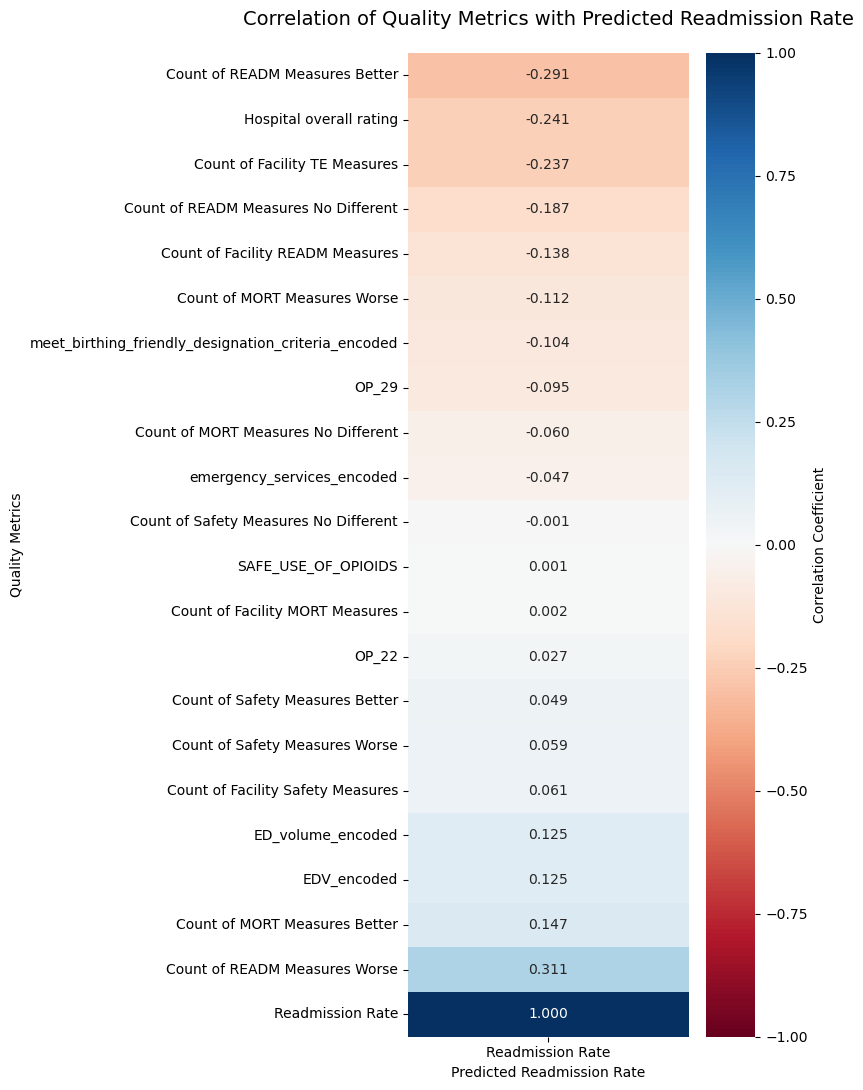

In [83]:
# Update the filtered data to include ED volume encoding
rrp_ha_tec_filtered_with_ed = full_table.with_columns(
    pl.when(pl.col("EDV") == "low")
    .then(1)
    .when(pl.col("EDV") == "medium")
    .then(2)
    .when(pl.col("EDV") == "high")
    .then(3)
    .when(pl.col("EDV")=="very high")
    .then(4)
    .otherwise(None)
    .cast(pl.Float64)
    .alias("ED_volume_encoded")
)

# Recalculate correlation matrix with ED volume

corr_mat_with_ed = rrp_ha_tec_filtered_with_ed.drop(["Facility Name","EDV","Facility ID", "State", "Hospital Ownership", "Emergency Services", "Meets criteria for birthing friendly designation"]).to_pandas().corr()

# Display the updated correlations
corr_series_with_ed = corr_mat_with_ed['Readmission Rate'].sort_values()
print("\nUpdated Correlations with ED Volume:")
print(corr_series_with_ed)

# Create updated heatmap
plt.figure(figsize=(8, 11))
corr_vertical_with_ed = pd.DataFrame(corr_series_with_ed)
sns.heatmap(corr_vertical_with_ed, annot=True, fmt='.3f', cmap='RdBu', center=0,
            cbar_kws={'label': 'Correlation Coefficient'},
            vmin=-1, vmax=1)
plt.title('Correlation of Quality Metrics with Predicted Readmission Rate', fontsize=14, pad=20)
plt.xlabel('Predicted Readmission Rate')
plt.ylabel('Quality Metrics')
plt.tight_layout()
plt.show()



### LASSO Regression for Feature Selection
In order to identify which quality of care metrics are most important for predicting readmission rates, I will perform a LASSO (Least Absolute Shrinkage and Selection Operator) regression analysis. LASSO adds a penalty term to the regression that can shrink coefficients to exactly zero, effectively performing feature selection. This will help identify which variables have the strongest predictive power for readmission rates.

### LASSO Regression

In [18]:
# Import necessary libraries for LASSO
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Prepare data for LASSO
# First, identify columns to exclude (identifiers, dates, categorical text)
identifier_cols = ['Facility ID', 'Facility Name']

# Categorical columns that need encoding
categorical_cols = ['Hospital Ownership', 'EDV']

# Get all columns in filtered table
available_cols = full_table.columns

# Filter identifier columns to only those present in the filtered table
identifier_cols_present = [col for col in identifier_cols if col in available_cols]

print(f"Columns in full_table_filtered: {len(available_cols)}")
print(f"Identifier columns to exclude: {len(identifier_cols_present)}")
print(f"\nIdentifier columns: {identifier_cols_present}")

Columns in full_table_filtered: 25
Identifier columns to exclude: 2

Identifier columns: ['Facility ID', 'Facility Name']


In [19]:
# Encode categorical variables and prepare features
lasso_data_filtered = full_table
# Create mapping of EDV Column: 
EDV_mapping = {'low':0,'medium':1,'high':2,'very high':3}
# Map birthing criteria column: 
BC_mapping = {"Y":1, "N":0}
# Emergency Services Mapping: 
ES_mapping = {"Yes":1, "No":0}

full_table=full_table.with_columns(
    pl.col("EDV")
      .replace_strict(EDV_mapping, default="Unknown")
      .alias("EDV_encoded")
      .cast(pl.Int64),
    pl.col("Meets criteria for birthing friendly designation")
      .replace_strict(BC_mapping, default="Unknown")
      .alias("meet_birthing_friendly_designation_criteria_encoded")
      .cast(pl.Int64),
    pl.col("Emergency Services")
      .replace_strict(ES_mapping, default="Unknown")
      .alias("emergency_services_encoded").cast(pl.Int64)
)

# One-hot encode Hospital Ownership
if "Hospital Ownership" in available_cols:
    ownership_types = full_table["Hospital Ownership"].unique().to_list()
    ownership_types = [ot for ot in ownership_types if ot is not None and ot.lower() != "not available"]
    print(f"Hospital Ownership Types: {ownership_types}")
    
    for ownership_type in ownership_types:
        lasso_data_filtered = lasso_data_filtered.with_columns(
            pl.when(pl.col("Hospital Ownership") == ownership_type)
            .then(1)
            .otherwise(0)
            .alias(f"Ownership_{ownership_type.replace(' ', '_').replace('/', '_').replace('-', '_')}")
        )

print(f"\nShape after encoding: {lasso_data_filtered.shape}")

lasso_data_filtered.head(1)

Hospital Ownership Types: ['Government - Local', 'Physician', 'Proprietary', 'Tribal', 'Government - State', 'Voluntary non-profit - Church', 'Government - Federal', 'Voluntary non-profit - Private', 'Government - Hospital District or Authority', 'Voluntary non-profit - Other']

Shape after encoding: (1573, 35)


Facility Name,Facility ID,State,Readmission Rate,EDV,OP_22,OP_29,SAFE_USE_OF_OPIOIDS,Hospital Ownership,Emergency Services,Meets criteria for birthing friendly designation,Hospital overall rating,Count of Facility MORT Measures,Count of MORT Measures Better,Count of MORT Measures No Different,Count of MORT Measures Worse,Count of Facility Safety Measures,Count of Safety Measures Better,Count of Safety Measures No Different,Count of Safety Measures Worse,Count of Facility READM Measures,Count of READM Measures Better,Count of READM Measures No Different,Count of READM Measures Worse,Count of Facility TE Measures,Ownership_Government___Local,Ownership_Physician,Ownership_Proprietary,Ownership_Tribal,Ownership_Government___State,Ownership_Voluntary_non_profit___Church,Ownership_Government___Federal,Ownership_Voluntary_non_profit___Private,Ownership_Government___Hospital_District_or_Authority,Ownership_Voluntary_non_profit___Other
str,str,str,f64,str,f64,f64,f64,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
"""SOUTHEAST HEALTH MEDICAL CENTE…","""010001""","""AL""",13.0146,"""high""",5.0,72.0,12.0,"""Government - Hospital District…","""Yes""","""Y""","""4""",7.0,0.0,7.0,0.0,7.0,3.0,4.0,0.0,11.0,0.0,11.0,0.0,11.0,0,0,0,0,0,0,0,0,1,0


In [84]:
# Select features for LASSO - exclude identifiers and original categorical columns
exclude_for_lasso = identifier_cols_present + ['Hospital Ownership', 'State', 'Meets criteria for birthing friendly designation',
                                                 'Emergency Services', 'EDV', 'Readmission Rate']

# Get all numeric and encoded columns
feature_cols = [col for col in lasso_data_filtered.columns if col not in exclude_for_lasso]

print(f"Number of features for LASSO: {len(feature_cols)}")
print(f"\nFeatures to use:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i}. {col}")

# Prepare X (features) and y (target)
X_lasso = lasso_data_filtered.select(feature_cols).to_pandas()
y_lasso = lasso_data_filtered.select('Readmission Rate').to_pandas()['Readmission Rate']


Number of features for LASSO: 27

Features to use:
1. OP_22
2. OP_29
3. SAFE_USE_OF_OPIOIDS
4. Hospital overall rating
5. Count of Facility MORT Measures
6. Count of MORT Measures Better
7. Count of MORT Measures No Different
8. Count of MORT Measures Worse
9. Count of Facility Safety Measures
10. Count of Safety Measures Better
11. Count of Safety Measures No Different
12. Count of Safety Measures Worse
13. Count of Facility READM Measures
14. Count of READM Measures Better
15. Count of READM Measures No Different
16. Count of READM Measures Worse
17. Count of Facility TE Measures
18. Ownership_Government___Local
19. Ownership_Physician
20. Ownership_Proprietary
21. Ownership_Tribal
22. Ownership_Government___State
23. Ownership_Voluntary_non_profit___Church
24. Ownership_Government___Federal
25. Ownership_Voluntary_non_profit___Private
26. Ownership_Government___Hospital_District_or_Authority
27. Ownership_Voluntary_non_profit___Other


In [ ]:
# Remove rows where target variable is null
valid_indices = y_lasso.notna()
X_lasso_clean = X_lasso[valid_indices]
y_lasso_clean = y_lasso[valid_indices]


Missing data summary:
  Features with >0% missing: 0

Top 10 features by missing percentage:
OP_22                                                    0.0
Count of READM Measures No Different                     0.0
Ownership_Government___Hospital_District_or_Authority    0.0
Ownership_Voluntary_non_profit___Private                 0.0
Ownership_Government___Federal                           0.0
Ownership_Voluntary_non_profit___Church                  0.0
Ownership_Government___State                             0.0
Ownership_Tribal                                         0.0
Ownership_Proprietary                                    0.0
Ownership_Physician                                      0.0
dtype: float64


In [22]:
# Split data into train and test sets
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(
    X_lasso_clean, y_lasso_clean, test_size=0.2, random_state=25
)

print(f"\nTraining set: {X_train_lasso.shape}")
print(f"Test set: {X_test_lasso.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lasso)
X_test_scaled = scaler.transform(X_test_lasso)

print(f"  Training set shape: {X_train_scaled.shape}")
print(f"  Test set shape: {X_test_scaled.shape}")
print(f"  Training set nulls: {np.isnan(X_train_scaled).sum()}")
print(f"  Test set nulls: {np.isnan(X_test_scaled).sum()}")

# Standardize features (required for LASSO)
scaler_lasso = StandardScaler()
X_train_scaled_lasso = scaler_lasso.fit_transform(X_train_scaled)
X_test_scaled_lasso = scaler_lasso.transform(X_test_scaled)

print("\n Data prepared for LASSO regression")
print(f"Final feature count: {X_train_scaled_lasso.shape[1]}")


Training set: (1258, 27)
Test set: (315, 27)
  Training set shape: (1258, 27)
  Test set shape: (315, 27)
  Training set nulls: 0
  Test set nulls: 0

 Data prepared for LASSO regression
Final feature count: 27


In [23]:
# Train LASSO with cross-validation
print("Training LassoCV model...")
lasso_cv_full = LassoCV(cv=5, random_state=25, max_iter=10000, n_alphas=100)
lasso_cv_full.fit(X_train_scaled_lasso, y_train_lasso)

print(f"Optimal alpha: {lasso_cv_full.alpha_:.6f}")
print(f"Number of features selected: {np.sum(lasso_cv_full.coef_ != 0)}")
print(f"Number of features eliminated: {np.sum(lasso_cv_full.coef_ == 0)}")

# Make predictions
y_train_pred_lasso = lasso_cv_full.predict(X_train_scaled_lasso)
y_test_pred_lasso = lasso_cv_full.predict(X_test_scaled_lasso)

# Evaluate model
train_r2 = r2_score(y_train_lasso, y_train_pred_lasso)
test_r2 = r2_score(y_test_lasso, y_test_pred_lasso)
train_rmse = np.sqrt(mean_squared_error(y_train_lasso, y_train_pred_lasso))
test_rmse = np.sqrt(mean_squared_error(y_test_lasso, y_test_pred_lasso))
train_mae = mean_absolute_error(y_train_lasso, y_train_pred_lasso)
test_mae = mean_absolute_error(y_test_lasso, y_test_pred_lasso)

print(f"\n{'='*60}")
print("Model Performance:")
print(f"{'='*60}")
print(f"Training R²:   {train_r2:.4f}")
print(f"Test R²:       {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE:     {test_rmse:.4f}")
print(f"Training MAE:  {train_mae:.4f}")
print(f"Test MAE:      {test_mae:.4f}")
print(f"{'='*60}")

Training LassoCV model...
Optimal alpha: 0.020593
Number of features selected: 18
Number of features eliminated: 9

Model Performance:
Training R²:   0.2695
Test R²:       0.2261
Training RMSE: 1.7021
Test RMSE:     1.7237
Training MAE:  1.3297
Test MAE:      1.3519


/opt/anaconda3/envs/data512/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


In [77]:
# Extract feature importance (coefficients)
# Note: X_lasso_clean may have had columns removed if they were all-null
# The final feature names are those that made it through to training
final_feature_names = X_lasso_clean.columns.tolist()

print(f"Features in X_lasso_clean: {len(final_feature_names)}")
print(f"Coefficients from LASSO: {len(lasso_cv_full.coef_)}")

# Verify they match
if len(final_feature_names) != len(lasso_cv_full.coef_):
    print(f"\n Expected {len(final_feature_names)} coefficients but got {len(lasso_cv_full.coef_)}")
    print("This likely means some columns were dropped during imputation or had issues.")
else:
    print("Dimensions match\n")

feature_importance = pd.DataFrame({
    'Feature': final_feature_names,
    'Coefficient': lasso_cv_full.coef_
})

# Separate selected and eliminated features
selected_features = feature_importance[feature_importance['Coefficient'] != 0].sort_values('Coefficient', key=abs, ascending=False)
eliminated_features = feature_importance[feature_importance['Coefficient'] == 0]



Features in X_lasso_clean: 27
Coefficients from LASSO: 27
Dimensions match



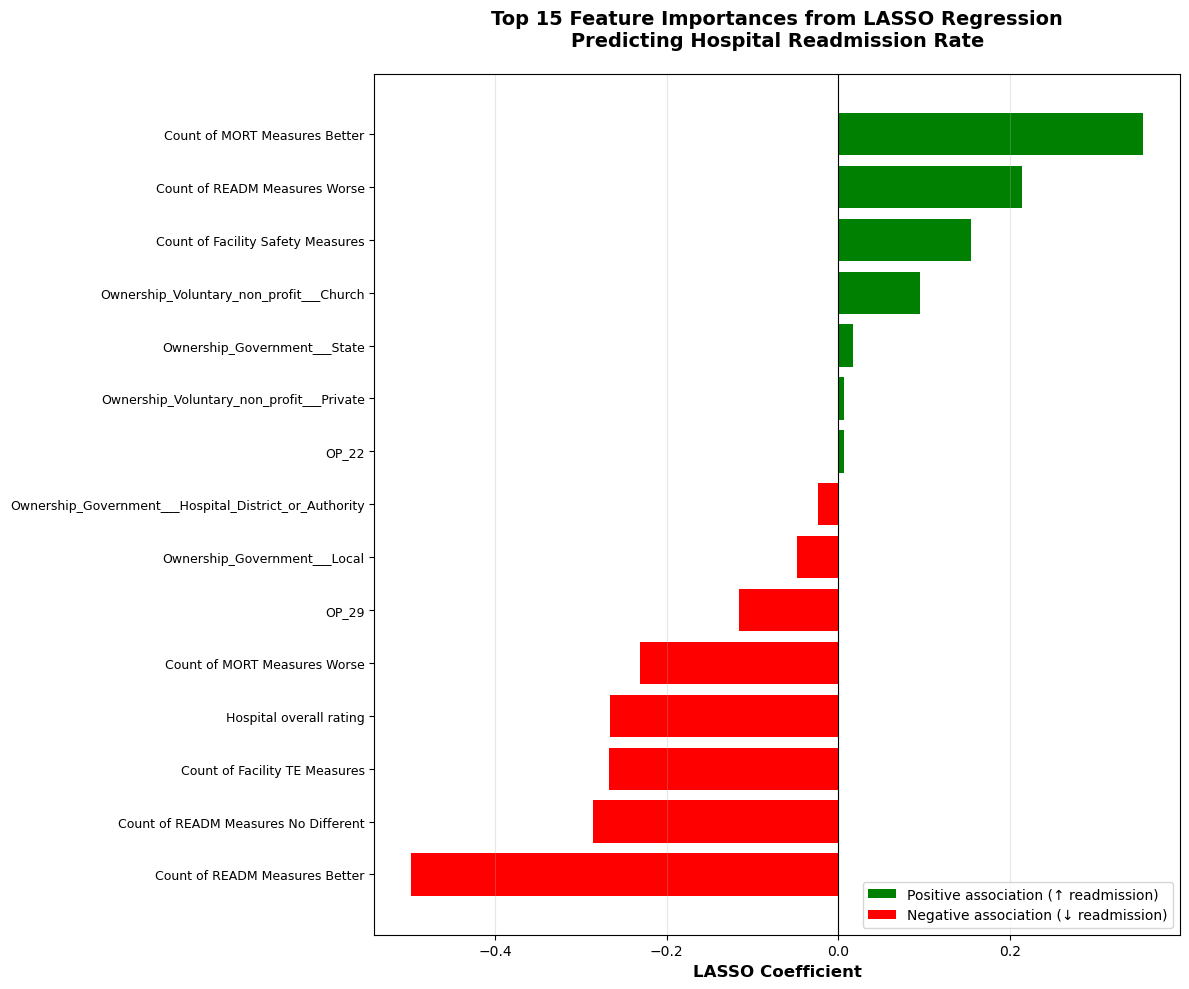

In [78]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 10))

# Get top 25 features by absolute coefficient value
top_features = selected_features.head(15).sort_values('Coefficient')

# Create color map (positive = green, negative = red)
colors_bar = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]

# Create horizontal bar chart
bars = ax.barh(range(len(top_features)), top_features['Coefficient'], color=colors_bar)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'], fontsize=9)
ax.set_xlabel('LASSO Coefficient', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Feature Importances from LASSO Regression\nPredicting Hospital Readmission Rate', 
             fontsize=14, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', label='Positive association (↑ readmission)'),
                   Patch(facecolor='red', label='Negative association (↓ readmission)')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

# Linear Regression

Next, I will be fitting a linear regression model on the data to try and predict a hospital's readmission rate. I will be carrying over the selected features that were found from the LASSO analysis above. This is because they should be the most informative features from the dataset. 

In [ ]:
selected_columns = selected_features['Feature'].tolist()
X = X_lasso_clean[selected_columns]

y_reg = y_lasso_clean

# Split data into training and testing sets
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=25)

model = LinearRegression()
model.fit(X_train, y_train_reg)

# 4. Make predictions on the test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
linear_mae = mean_absolute_error(y_test_reg, y_pred)
linear_rsquared = r2_score(y_test_reg, y_pred)
print(f"Mean Abs error: {linear_mae:.3f}")
print(f"R^2: {linear_rsquared:.3f}")

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False, 'tol': 1e-06}
Mean Abs error: 1.360
R^2: 0.219


# Random Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 500, 800],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train_reg)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print(best_params, best_estimator)


# # Create a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=best_params['n_estimators'], random_state=25, min_samples_leaf=best_params['min_samples_leaf'], min_samples_split=best_params['min_samples_split'], max_depth=best_params['max_depth'], max_features=best_params['max_features'])

# # Train the model
rf_regressor.fit(X_train, y_train_reg)

{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300} RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=300, random_state=42)


,n_estimators,300
,criterion,'squared_error'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [32]:
# Make predictions on the test set
y_pred_reg = rf_regressor.predict(X_test)
y_pred_train_reg = rf_regressor.predict(X_train)

# Evaluate the model
train_mae = mean_absolute_error(y_train_reg,y_pred_train_reg)
train_mse = mean_squared_error(y_train_reg,y_pred_train_reg)
train_r_squared = r2_score(y_train_reg,y_pred_train_reg)

mse = mean_squared_error(y_test_reg, y_pred_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r_squared = r2_score(y_test_reg,y_pred_reg)
feature_importance.sort_values(by='Coefficient')
print("TRAINING SET METRICS: ")
print(f"Random Forest Regressor Mean Abs Error: {round(train_mae,4)}")
print(f"Random Forest Regressor Mean Squared Error: {round(train_mse,4)}")
print(f"Random Forest Regressor R^2: {round(train_r_squared,4)}")
print("="*80)
print("TEST SET METRICS: ")
print(f"Random Forest Regressor Mean Squared Error: {round(mse,4)}")
print(f"Random Forest Regressor Mean Abs Error: {round(mae,4)}")
print(f"Random Forest Regressor R^2: {round(r_squared,4)}")

TRAINING SET METRICS: 
Random Forest Regressor Mean Abs Error: 1.0706
Random Forest Regressor Mean Squared Error: 1.8724
Random Forest Regressor R^2: 0.5278
TEST SET METRICS: 
Random Forest Regressor Mean Squared Error: 3.0826
Random Forest Regressor Mean Abs Error: 1.3724
Random Forest Regressor R^2: 0.1971
